In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"   # Force CUDA to be synchronous

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

from tqdm.notebook import tqdm
import re
from datasets import Dataset, DatasetDict

## 1. Data Loading and Initial Exploration

In this section, we load the training dataset and perform an initial exploratory analysis:  
- Check the shape and structure of the data  
- View several sample rows  
- Visualize class and year distributions  
- Calculate the average and median length of texts


In [2]:
DATASET = pd.read_csv("train.csv")

In [3]:
df = DATASET

print("Number of samples:", len(df))
print("Columns:", df.columns.tolist())
print("Number of unique classes:", df['class'].nunique())
print("Years in the dataset:", sorted(df['year'].unique()))

display(df.sample(10))


Number of samples: 216974
Columns: ['id', 'text', 'class', 'year']
Number of unique classes: 21
Years in the dataset: [np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020)]


,id,text,class,year
59626,59626,Aprovació inicial del pressupost per a l'exerc...,12,2014
197165,197165,Aprovació definitiva de dos projectes (1832/17...,0,2020
153826,153826,Delegació de la signatura del secretari genera...,9,2018
153059,153059,Conveni col·lectiu de treball de l'empresa Ren...,1,2018
184410,184410,Aprovació definitiva del Codi de conducta dels...,3,2019
93735,93735,Aprovació inicial del canvi de sistema de gest...,19,2015
121863,121863,Resolució d'audiència prèvia a l'ordre d'execu...,17,2016
5606,5606,Licitació del servei de connexió a Internet a ...,0,2013
20865,20865,Aprovació definitiva de la modificació de la p...,12,2013
51026,51026,Oferta pública d'ocupació per a l'any 2014.,5,2014


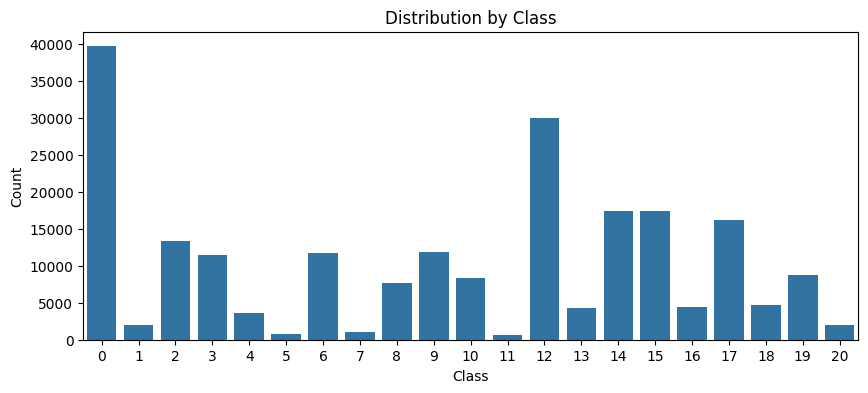

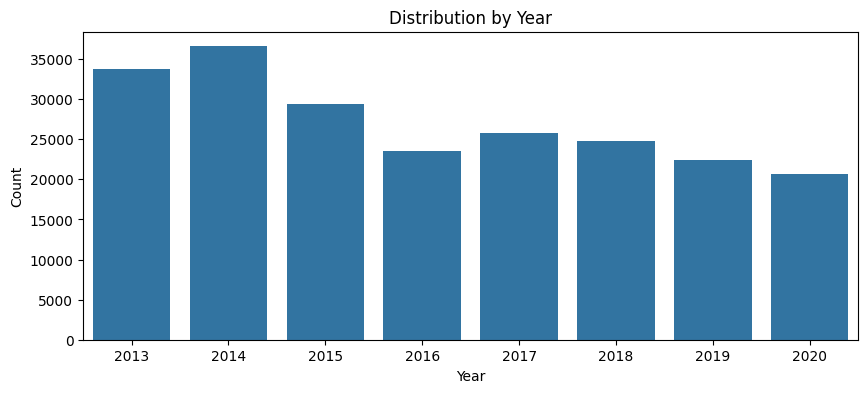

In [4]:
# Plot the distribution of samples across classes to identify any class imbalance, which can affect training and evaluation.
plt.figure(figsize=(10,4))
sns.countplot(x='class', data=df)
plt.title('Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plot the distribution of samples by year to check for temporal patterns or data skews that may influence model generalization.
plt.figure(figsize=(10,4))
sns.countplot(x='year', data=df)
plt.title('Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()


In [5]:
# Compute the length of each text in characters; this helps in understanding text size variability and guides preprocessing (e.g., max sequence length for BERT).
df['text_len_chars'] = df['text'].str.len()

# Compute the length of each text in words to get additional statistics about text complexity and to compare with character-based length.
df['text_len_words'] = df['text'].str.split().apply(len)

# Output average and median values to summarize dataset and support decisions on padding/truncation for modeling.
print("Average text length (characters):", df['text_len_chars'].mean())
print("Median text length (characters):", df['text_len_chars'].median())
print("Average text length (words):", df['text_len_words'].mean())
print("Median text length (words):", df['text_len_words'].median())


Average text length (characters): 99.16521334353425
Median text length (characters): 94.0
Average text length (words): 14.576990791523409
Median text length (words): 14.0


### Summary of Data Exploration

- The dataset shows a strong class imbalance:
  - Classes 0 and 12 are much more frequent than others.
  - Several classes (such as 5, 7, 13, 15, and 20) have very few samples, which may lead to poor generalization for these classes.
- The average text is short (~99 characters or ~14 words).
- Year distribution is skewed toward earlier years (2013–2014).

**To mitigate the impact of class imbalance, we will:**
- Use stratified train/validation split to preserve class proportions during training and evaluation.
- Monitor not only overall accuracy but also macro-F1 and the confusion matrix to assess performance across all classes, including minority ones.
- Consider implementing class weights in the loss function if we observe poor recognition of rare classes during validation.


## 2. Text Cleaning and Basic Preprocessing

In this section:
- Convert all texts to lowercase.
- Remove special characters, keeping only letters, numbers, and spaces.
- Stopwords (including Catalan function words) are intentionally preserved, as transformer-based models benefit from full sentence structure.
- Analyze how text cleaning affects text length and update statistics.

In [6]:
def clean_text(text):
    # Convert all characters to lowercase for normalization and to reduce vocabulary size for the model.
    text = text.lower()
    # Remove all characters except letters (including accented), digits, and spaces to standardize input for tokenization.
    text = re.sub(r'[^a-zà-ÿ0-9\s]', '', text)
    # Replace multiple consecutive spaces with a single space and trim edges to avoid artificial token inflation.
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
df['clean_text'] = df['text'].apply(clean_text)

### Analyze the Effect of Text Cleaning

Compare average and median lengths of original and cleaned texts to understand the impact of preprocessing.


In [8]:
# Recalculate character and word lengths after cleaning to check if cleaning significantly shortens the text or changes its structure.
df['clean_len_chars'] = df['clean_text'].str.len()
df['clean_len_words'] = df['clean_text'].str.split().apply(len)

# Print updated statistics to support decisions about input sequence length for the model.
print("Average cleaned text length (characters):", df['clean_len_chars'].mean())
print("Median cleaned text length (characters):", df['clean_len_chars'].median())
print("Average cleaned text length (words):", df['clean_len_words'].mean())
print("Median cleaned text length (words):", df['clean_len_words'].median())


Average cleaned text length (characters): 96.20189515794519
Median cleaned text length (characters): 92.0
Average cleaned text length (words): 14.565832772590264
Median cleaned text length (words): 14.0


### Conclusion

No significant changes in text length after cleaning.


## 3. Train/Validation Split

We perform a stratified split to preserve class proportions in both the training and validation sets, which helps mitigate class imbalance during model training and evaluation.


In [9]:
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['class'], 
    random_state=2025
)

# Rename target column to 'labels' for Trainer compatibility
train_df = train_df.rename(columns={"class": "labels"})
val_df   = val_df.rename(columns={"class": "labels"})

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))

Training samples: 173579
Validation samples: 43395


## 4. Tokenization and Preparation for Training

- Select a BERT model en catalan
- Load the tokenizer using AutoTokenizer.
- Tokenize the texts and prepare PyTorch datasets for the Trainer.


In [10]:
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"

# Load the pretrained BERT tokenizer to convert texts into input IDs and attention masks.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

max_length = 32  # Chosen based on the actual distribution: most texts have <= 14 words, 32 covers almost all cases.

def tokenize_batch(batch):
    # Tokenize texts, truncating or padding to a fixed max_length for batch processing.
    return tokenizer(
        batch["clean_text"], 
        padding="max_length", 
        truncation=True, 
        max_length=max_length
    )

# Prepare data for HuggingFace Trainer by converting DataFrame to Dataset.
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Apply tokenization to the datasets.
train_dataset = train_dataset.map(tokenize_batch, batched=True)
val_dataset = val_dataset.map(tokenize_batch, batched=True)


Map:   0%|          | 0/173579 [00:00<?, ? examples/s]

Map:   0%|          | 0/43395 [00:00<?, ? examples/s]

## 5. Model Building and Training

- Load the RoBERTa-base Catalan model (`PlanTL-GOB-ES/roberta-base-ca`) for sequence classification (21 output classes).
- Define training parameters with TrainingArguments.
- Train the model using Huggingface Trainer.
- Save the best model checkpoint based on validation accuracy.


In [11]:
# Use the Catalan RoBERTa-base model for sequence classification
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=21)

training_args = TrainingArguments(
    output_dir='./roberta-ca-results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=100,
    report_to="none",
    seed=42
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/shared/Documentos/Master/neuro/projext/neuro/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    # Evaluate classification accuracy for validation, as required by project grading.
    return {"accuracy": accuracy_score(labels, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

# Save the best model for later inference and submission.
trainer.save_model("./best_roberta_ca_model")


Unique labels in train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Train labels dtype: <class 'int'>
Label distribution: Counter({0: 31696, 12: 23982, 14: 13936, 15: 13922, 17: 12954, 2: 10620, 9: 9504, 6: 9322, 3: 9144, 19: 6959, 10: 6641, 8: 6113, 18: 3782, 16: 3540, 13: 3408, 4: 2868, 20: 1630, 1: 1547, 7: 801, 5: 672, 11: 538})


  0%|          | 0/32547 [00:00<?, ?it/s]

{'loss': 2.1781, 'grad_norm': 2.9904849529266357, 'learning_rate': 1.9938550404031096e-05, 'epoch': 0.01}
{'loss': 1.0496, 'grad_norm': 4.346735954284668, 'learning_rate': 1.9877100808062188e-05, 'epoch': 0.02}
{'loss': 0.6725, 'grad_norm': 5.5642008781433105, 'learning_rate': 1.9815651212093282e-05, 'epoch': 0.03}
{'loss': 0.5001, 'grad_norm': 2.14245343208313, 'learning_rate': 1.9754201616124377e-05, 'epoch': 0.04}
{'loss': 0.408, 'grad_norm': 3.248873472213745, 'learning_rate': 1.969275202015547e-05, 'epoch': 0.05}
{'loss': 0.3617, 'grad_norm': 4.564384460449219, 'learning_rate': 1.9631302424186563e-05, 'epoch': 0.06}
{'loss': 0.3708, 'grad_norm': 6.609285831451416, 'learning_rate': 1.9569852828217658e-05, 'epoch': 0.06}
{'loss': 0.2828, 'grad_norm': 3.042863368988037, 'learning_rate': 1.950840323224875e-05, 'epoch': 0.07}
{'loss': 0.2944, 'grad_norm': 6.309263229370117, 'learning_rate': 1.9446953636279844e-05, 'epoch': 0.08}
{'loss': 0.2798, 'grad_norm': 5.327764987945557, 'learnin